SADFasf asf asfasf as ASf a

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


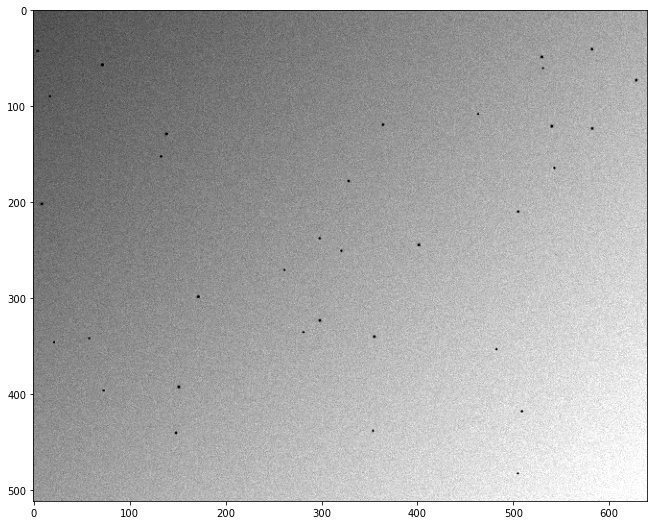

In [12]:
%load_ext autoreload
%autoreload 2

from loader import *
from models import *
from utils import *
from plotting import *

im_size_width, im_size_height, radius = 640, 512, 0.3e-6
plankton = stationary_spherical_plankton(im_size_height, im_size_width, radius, label=0)

gradient_amp = 0.5
microscope = plankton_brightfield(im_size_height, im_size_width, gradient_amp)

no_of_planktons = 50
sample = create_sample(plankton, no_of_planktons)

noise_amp = 2
norm_min, norm_max= -0.2, 1.2
image = create_image(noise_amp, sample, microscope, norm_min, norm_max)

plot_image(image)

In [ ]:
label = get_target_image(image.resolve())
label_function = get_target_image
plot_label(label_function, image)

In [ ]:
batch_function = create_custom_batch_function(image, 
                                              outputs=[0], 
                                              function_img=[Normalize_image],
                                              function_diff=[Normalize_image])

In [ ]:
from deeptrack.generators import ContinuousGenerator
generator = ContinuousGenerator(
    image,
    get_target_image,
    batch_function,
    batch_size=2,
    min_data_size=4,
    max_data_size=512
    )

In [ ]:
no_of_inputs, number_of_outputs = 1, 2
model = generate_unet(im_size_height, im_size_width, no_of_inputs, number_of_outputs)
model = train_model_early_stopping(model, generator, patience=20, epochs=20, steps_per_epoch=2)

In [ ]:
# outputs = ["img", "img", "img", "diff", "diff"]
# output_numbers = [0, 1, 2, [0,1], [1,2]]
folder_path = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\raw_output\\raw_output_images'
calculated_mean_image = get_mean_image(folder_path, im_size_width, im_size_height)
im_stack = get_image_stack(
    outputs=[[0,1], [1,2]], 
    folder_path=folder_path, 
    frame_im0=16, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    function_img=[Normalize_image],
    function_diff=[Normalize_image])

plot_image_stack(im_stack)
plot_prediction(model=model, im_stack=im_stack)

In [ ]:
positions = extract_positions(
    no_of_frames=10, 
    outputs=[[0,1], [1,2]], 
    folder_path=folder_path, 
    frame_im0=17, 
    im_size_width=640, 
    im_size_height=512,
    im_resize_width=640, 
    im_resize_height=512,
    model=model, 
    layer=1, 
    value_threshold=0.3,
    function_img=[Normalize_image],
    function_diff=[Normalize_image])


In [ ]:
list_of_plankton = assign_positions_to_planktons(positions, max_dist=10, threshold=11, extrapolate=True)
# list_of_plankton = Interpolate_gaps_in_plankton_positions(list_of_plankton=list_of_plankton)
# list_of_plankton = Trim_list_from_stationary_planktons(list_of_plankton=list_of_plankton, min_distance=0)

# plankton_track, plankton_dont_track = split_plankton(list_of_plankton=list_of_plankton, percentage_threshold=0)

In [ ]:
plot_and_save_track(no_of_frames=len(list_of_plankton[list(list_of_plankton.keys())[0]].positions),
                    plankton_track=list_of_plankton,
                    plankton_dont_track=plankton_dont_track,
                    folder_path=folder_path,
                    frame_im0=18,
                    save_images=False,
                    show_plankton_track=True,
                    show_plankton_dont_track=0,
                    show_numbers_track=0,
                    show_numbers_dont_track=0,
                    show_numbers_specific_plankton=False,
                    show_specific_plankton=False,
                    specific_plankton=None,
                    color_plankton_track='b',
                    color_plankton_dont_track='r',
                    color_specific_plankton='w',
                    x_axis_label='microns',
                    y_axis_label='microns',
                    pixel_length_ratio=3,
                    save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output',
                    frame_name='track',
                    file_type='.jpg')


In [ ]:
mean_net_distance, mean_gross_distances = get_mean_net_and_gross_distance(list_of_plankton, use_3D_dist=False)


In [ ]:
plot_net_vs_gross_distance(list_of_plankton=plankton_track)

In [ ]:
# Make_video(frame_im0=20,
#            folder_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Raw_output', 
#            save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\New imulations\\Test_video.avi', 
#            fps=7, 
#            no_of_frames=40)

In [ ]:
# save_positions(list_of_plankton, 
#                save_path='E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\DeepTrack-2.0\\projects\\track plankton', 
#                file_format='.csv', 
#                pixel_length_ratio=1)

In [ ]:
save_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\DeepTrack-2.0\\projects\\track plankton\\test_save.keras'
model.save(save_path_model)

In [ ]:
load_path_model = 'E:\\Documents\\Anaconda\\Jupyterkod\\Exjobb\\Egen kod\\Exjobb\\Test simulations\\raw_output\\results\\jupyter_ver9copy\\models\\seq_len3_b1norm_noclip_3out_16-32-64-128.keras'

model = keras.models.load_model(load_path_model, custom_objects={'softmax_categorical':softmax_categorical})